# Packages & Directory

The necessary packages are installed and imported

In [ ]:
!pip install sdv      #please restart runtime when asked to do so

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 6.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0


In [ ]:
## dataframe
import pandas as pd

##plotting
import matplotlib.pyplot as plt
import seaborn as sns

## data generation 
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer

## data privacy
from rdt.transformers import PseudoAnonymizedFaker 

## evaluation
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot

## synthetic data metrics 
from sdmetrics.single_column import MissingValueSimilarity
from sdmetrics.single_table import CategoricalCAP

## miscellanous
import time
import math 

The working directory is also set to read and save the dataset to the local directory on google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/DSA4266/betterdata

/content/drive/MyDrive/DSA4266/betterdata


# Real Data 

Read the target dataset. Note that only the target table is used to generate synthetic data since the remaining tables are have only 2 columns, each of them with unique values (primary key). Hence, it does not make sense to generate them.

In [ ]:
real_data = pd.read_csv('Datasets/Real/target.csv', low_memory = False)

## Primary Keys

The table is checked for the primary/candidate keys. The idea is to find the group of column(s) that uniquely identify each row in the dataset.

In [ ]:
len(real_data[['TailNum','FlightDate', 'FlightNum', 'AirlineID', 'CRSDepTime']].drop_duplicates()) == len(real_data)

True

In [ ]:
real_data[real_data[['TailNum','FlightDate', 'FlightNum', 'AirlineID', 'CRSDepTime']].duplicated()]

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime


`'TailNum','FlightDate', 'FlightNum', 'AirlineID', 'CRSDepTime'` is our candidate key

## Data Structure

The data structure is checked once again before it used for the synthesizers.

In [ ]:
real_data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginState',
       'OriginStateFips', 'OriginWac', 'DestAirportID', 'DestAirportSeqID',
       'DestCityMarketID', 'Dest', 'DestState', 'DestStateFips', 'DestWac',
       'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff',
       'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 'DistanceGroup',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 'LongestAddGTime',
       'DivAirportLandings', 'DivReachedD

In [ ]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 78 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  445827 non-null  int64  
 1   Quarter               445827 non-null  int64  
 2   Month                 445827 non-null  int64  
 3   DayofMonth            445827 non-null  int64  
 4   DayOfWeek             445827 non-null  int64  
 5   FlightDate            445827 non-null  object 
 6   AirlineID             445827 non-null  int64  
 7   Carrier               445827 non-null  object 
 8   TailNum               441583 non-null  object 
 9   FlightNum             445827 non-null  int64  
 10  OriginAirportID       445827 non-null  int64  
 11  OriginAirportSeqID    445827 non-null  int64  
 12  OriginCityMarketID    445827 non-null  int64  
 13  Origin                445827 non-null  object 
 14  OriginState           445827 non-null  object 
 15  

In [ ]:
size_real = len(real_data)




## Cleaning Data 

Considering that the following columns containing hte details of flight cancellations/diversions contain large amounts of NA values as well as are not the main focus of the models, they will be dropped from the dataset. Note that this dataset is not tested until the fine tuned stage.

In [ ]:
clean_data = real_data.drop(columns = ['Cancelled', 'CancellationCode', 'CarrierDelay','WeatherDelay', 'NASDelay', 
                                       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 
                                       'LongestAddGTime', 'DivAirportLandings','DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay', 
                                       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 
                                       'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 
                                       'Div2Airport', 'Diverted','Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 
                                       'Div2TotalGTime', 'Div2LongestGTime', 'Flights'])
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 47 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  445827 non-null  int64  
 1   Quarter               445827 non-null  int64  
 2   Month                 445827 non-null  int64  
 3   DayofMonth            445827 non-null  int64  
 4   DayOfWeek             445827 non-null  int64  
 5   FlightDate            445827 non-null  object 
 6   AirlineID             445827 non-null  int64  
 7   Carrier               445827 non-null  object 
 8   TailNum               441583 non-null  object 
 9   FlightNum             445827 non-null  int64  
 10  OriginAirportID       445827 non-null  int64  
 11  OriginAirportSeqID    445827 non-null  int64  
 12  OriginCityMarketID    445827 non-null  int64  
 13  Origin                445827 non-null  object 
 14  OriginState           445827 non-null  object 
 15  

Verifiying that the NAs in the remaining columns relating to departure or arrival only occur when flights are cancelled or diverted.

In [ ]:
clean_data[clean_data['DepDelay'].isna()]

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,ArrTimeBlk,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,DivAirportLandings
72,2016,1,1,16,6,2016-01-16,19805,AA,N3CXAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
79,2016,1,1,23,6,2016-01-23,19805,AA,NaN,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
80,2016,1,1,24,7,2016-01-24,19805,AA,N3DGAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
81,2016,1,1,25,1,2016-01-25,19805,AA,N3MNAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
102,2016,1,1,15,5,2016-01-15,19805,AA,N3JSAA,45,...,2100-2159,1,0,382.0,NaN,NaN,1.0,2422.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444418,2016,1,1,25,1,2016-01-25,20366,EV,N13975,6136,...,0900-0959,1,0,74.0,NaN,NaN,1.0,195.0,1,0
445581,2016,1,1,26,2,2016-01-26,20366,EV,N14998,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0
445584,2016,1,1,25,1,2016-01-25,20366,EV,N14570,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0
445592,2016,1,1,23,6,2016-01-23,20366,EV,N15574,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0


In [ ]:
len(clean_data[clean_data['DepDelay'].isna() & (clean_data['Cancelled'] == 1)]) == len(clean_data[clean_data['DepDelay'].isna()])

True

In [ ]:
clean_data[clean_data['WheelsOn'].isna()]

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,ArrTimeBlk,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,DivAirportLandings
72,2016,1,1,16,6,2016-01-16,19805,AA,N3CXAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
79,2016,1,1,23,6,2016-01-23,19805,AA,NaN,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
80,2016,1,1,24,7,2016-01-24,19805,AA,N3DGAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
81,2016,1,1,25,1,2016-01-25,19805,AA,N3MNAA,44,...,1500-1559,1,0,321.0,NaN,NaN,1.0,2422.0,10,0
102,2016,1,1,15,5,2016-01-15,19805,AA,N3JSAA,45,...,2100-2159,1,0,382.0,NaN,NaN,1.0,2422.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444418,2016,1,1,25,1,2016-01-25,20366,EV,N13975,6136,...,0900-0959,1,0,74.0,NaN,NaN,1.0,195.0,1,0
445581,2016,1,1,26,2,2016-01-26,20366,EV,N14998,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0
445584,2016,1,1,25,1,2016-01-25,20366,EV,N14570,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0
445592,2016,1,1,23,6,2016-01-23,20366,EV,N15574,6033,...,1300-1359,1,0,83.0,NaN,NaN,1.0,282.0,2,0


In [ ]:
len(clean_data[(clean_data['WheelsOn'].isna()) & ((clean_data['Diverted'] == 1) | (clean_data['Cancelled'] == 1))]) == len(clean_data[clean_data['WheelsOn'].isna()])

True

# Preprocessing

Since the dataset is really large (400k+ rows), only a subset of this will be used to fit the synthesizer/generation model for the following reasons: 
<br> 1) This significantly reduces the training time
<br> 2) Better for evaluating the synthetic data and replicate real-life scenarios of data generation, where the data may be generated for sizes of 10-20 times. 

In [ ]:
samp_real_data = real_data.sample(frac=0.1,             #only 10% of dataset
                                  replace=False,        #no replacement
                                  random_state=4266)    #set seed for reproducibility

In [ ]:
samp_clean_data = clean_data.sample(frac=0.1,             #only 10% of dataset
                                  replace=False,        #no replacement
                                  random_state=4266)    #set seed for reproducibility

The metadata of the table, describing the columns and their types from the dataframe, is also extracted to be used for fitting the generative model as well as for the data evaluation. 

In [ ]:
metadata = SingleTableMetadata()

In [ ]:
metadata.detect_from_dataframe(data=samp_real_data)

In [ ]:
metadata

{
    "columns": {
        "Year": {
            "sdtype": "numerical"
        },
        "Quarter": {
            "sdtype": "numerical"
        },
        "Month": {
            "sdtype": "numerical"
        },
        "DayofMonth": {
            "sdtype": "numerical"
        },
        "DayOfWeek": {
            "sdtype": "numerical"
        },
        "FlightDate": {
            "sdtype": "categorical"
        },
        "AirlineID": {
            "sdtype": "numerical"
        },
        "Carrier": {
            "sdtype": "categorical"
        },
        "TailNum": {
            "sdtype": "categorical"
        },
        "FlightNum": {
            "sdtype": "numerical"
        },
        "OriginAirportID": {
            "sdtype": "numerical"
        },
        "OriginAirportSeqID": {
            "sdtype": "numerical"
        },
        "OriginCityMarketID": {
            "sdtype": "numerical"
        },
        "Origin": {
            "sdtype": "categorical"
        },
        "Orig

In [ ]:
metadata_clean = SingleTableMetadata()

In [ ]:
metadata_clean.detect_from_dataframe(data=samp_clean_data)

# Base SDV Generation

Firstly, the base models provided by SDV are explored

## Base SDV: Copula

Copula uses statistical methods to generate data

### Fitting & Sampling

In [ ]:
cop_generate = GaussianCopulaSynthesizer(
    metadata, 
    enforce_min_max_values=True,
    enforce_rounding=False
)

GaussianCopula does not support the usage of GPUs. Hence, the training + model generation time is limited by its ability to only run on CPU.

In [ ]:
start = time.time()
cop_generate.fit(samp_real_data)
end = time.time()

The rows are sampled

In [ ]:
start_gen = time.time()
cop_base_data = cop_generate.sample(
    num_rows=1_000_000,
    batch_size=5000
)
end_gen = time.time()

Sampling rows: 100%|██████████| 1000000/1000000 [05:56<00:00, 2807.48it/s]


In [ ]:
cop_base_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,2016,1,1,5,1,2016-01-16,19434,OO,N315US,3101,...,NaN,NaN,NaN,N624VA,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,8,6,2016-01-19,19551,DL,N991AT,846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,19,4,2016-01-15,19727,AA,N8314L,2387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,25,2,2016-01-03,20070,DL,N829UA,4438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,24,3,2016-01-16,19407,DL,N3DWAA,997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,30,6,2016-01-02,19412,B6,N627SW,4996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,2016,1,1,19,5,2016-01-06,19665,AA,N932WN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,2016,1,1,24,2,2016-01-28,19837,EV,N203WN,447,...,NaN,NaN,NaN,N335NB,SEA,NaN,NaN,NaN,NaN,NaN
999998,2016,1,1,29,3,2016-01-27,19964,NK,N922WN,2347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The model and dataset are saved

In [ ]:
synth_data_dir = 'Datasets/Synthetic'

In [ ]:
cop_base_data.to_csv(synth_data_dir + '/target_copula_base.csv', index = False)

In [ ]:
cop_generate.save(
    filepath='Models/Synthesizer/cop_base.pkl'
)

### Evaluation

The following evaluation metrics will be used throughout the notebook: 
<br> 1) Run Time 
<br> 2) Data quality
<br> 3) Diagnostics 
<br> 4) Column Plots of target variables

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  1.533679993947347 minutes


In [ ]:
print('Time to Generate Data', (end_gen - start_gen)/60, 'minutes')

Time to Generate Data 5.936938011646271 minutes


#### Quality

The quality tests how well the column shapes as well as the correlation between columns are retained. Not that due to the calculation of correlation, the following columns will have to be dropped in order ot output the quality report.

In [ ]:
cop_base_quality = cop_base_data.drop(columns = ['Cancelled', 'CancellationCode', 'CarrierDelay','WeatherDelay', 'NASDelay', 
                                       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 
                                       'LongestAddGTime', 'DivAirportLandings','DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay', 
                                       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 
                                       'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 
                                       'Div2Airport', 'Diverted','Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 
                                       'Div2TotalGTime', 'Div2LongestGTime', 'Flights'])

In [ ]:
samp_real_quality = samp_real_data.drop(columns = ['Cancelled', 'CancellationCode', 'CarrierDelay','WeatherDelay', 'NASDelay', 
                                       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 
                                       'LongestAddGTime', 'DivAirportLandings','DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay', 
                                       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 
                                       'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 
                                       'Div2Airport', 'Diverted','Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 
                                       'Div2TotalGTime', 'Div2LongestGTime', 'Flights'])
metadata_quality = SingleTableMetadata()
metadata_quality.detect_from_dataframe(data=samp_real_quality)

In [ ]:
cop_base_quality_report = evaluate_quality(
    real_data = samp_real_quality,
    synthetic_data = cop_base_quality.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_quality)

Creating report: 100%|██████████| 4/4 [00:44<00:00, 11.02s/it]



Overall Quality Score: 83.36%

Properties:
Column Shapes: 81.88%
Column Pair Trends: 84.84%


In [ ]:
cop_base_quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,Year,KSComplement,1.000000
1,Quarter,KSComplement,1.000000
2,Month,KSComplement,1.000000
3,DayofMonth,KSComplement,0.975905
4,DayOfWeek,KSComplement,0.924748
5,AirlineID,KSComplement,0.646024
6,FlightNum,KSComplement,0.932522
7,OriginAirportID,KSComplement,0.896106
8,OriginAirportSeqID,KSComplement,0.895986
9,OriginCityMarketID,KSComplement,0.906257


In [ ]:
cop_base_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
cop_base_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,Quarter,Year,CorrelationSimilarity,NaN,NaN,NaN
1,Month,Year,CorrelationSimilarity,NaN,NaN,NaN
2,DayofMonth,Year,CorrelationSimilarity,NaN,NaN,NaN
3,DayOfWeek,Year,CorrelationSimilarity,NaN,NaN,NaN
4,AirlineID,Year,CorrelationSimilarity,NaN,NaN,NaN
...,...,...,...,...,...,...
1076,ArrTimeBlk,CRSElapsedTime,ContingencySimilarity,0.879508,NaN,NaN
1077,ActualElapsedTime,ArrTimeBlk,ContingencySimilarity,0.878015,NaN,NaN
1078,AirTime,ArrTimeBlk,ContingencySimilarity,0.875146,NaN,NaN
1079,ArrTimeBlk,Distance,ContingencySimilarity,0.872815,NaN,NaN


In [ ]:
cop_base_quality_report.get_visualization(property_name='Column Pair Trends')

In [ ]:
cop_base_quality_report.save('Models/Reports/cop_base_quality.pkl')

#### Diagnostics

The diagnostics test how well the synthetic data covers the values and maintains the ranges present in the real data while also testing how new the rows are

In [ ]:
cop_base_diagnostic_report = run_diagnostic(
    real_data = samp_real_data,
    synthetic_data = cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [22:03<00:00, 330.96s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
! The synthetic data is missing more than 10% of the categories present in the real data


In [ ]:
cop_base_diagnostic_report.get_properties()

{'Coverage': 0.6239142366932019, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
cop_base_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,0.999866
4,OriginAirportID,RangeCoverage,1.000000
...,...,...,...
64,ArrTimeBlk,CategoryCoverage,1.000000
65,CancellationCode,CategoryCoverage,1.000000
66,Div1Airport,CategoryCoverage,0.081633
67,Div1TailNum,CategoryCoverage,0.076923


In [ ]:
cop_base_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
cop_base_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
cop_base_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
cop_base_diagnostic_report.get_details(property_name='Boundaries')

,Column,Metric,Diagnostic Score
0,Year,BoundaryAdherence,1.0
1,Quarter,BoundaryAdherence,1.0
2,Month,BoundaryAdherence,1.0
3,DayofMonth,BoundaryAdherence,1.0
4,DayOfWeek,BoundaryAdherence,1.0
...,...,...,...
60,Div2AirportID,BoundaryAdherence,1.0
61,Div2AirportSeqID,BoundaryAdherence,1.0
62,Div2WheelsOn,BoundaryAdherence,1.0
63,Div2TotalGTime,BoundaryAdherence,1.0


In [ ]:
cop_base_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
cop_base_diagnostic_report.save('Models/Reports/cop_base_diag_report.pkl')

The boundaries and synthesis are already 100% and hence will not be the main focus when improving the data generation.

#### Other Metrics

The target variables for arrival and departure delayes are checked for distribtuion. Additionally the frequency of cancelled and diverted flights present are also checked.

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='Cancelled',
    metadata=metadata
)

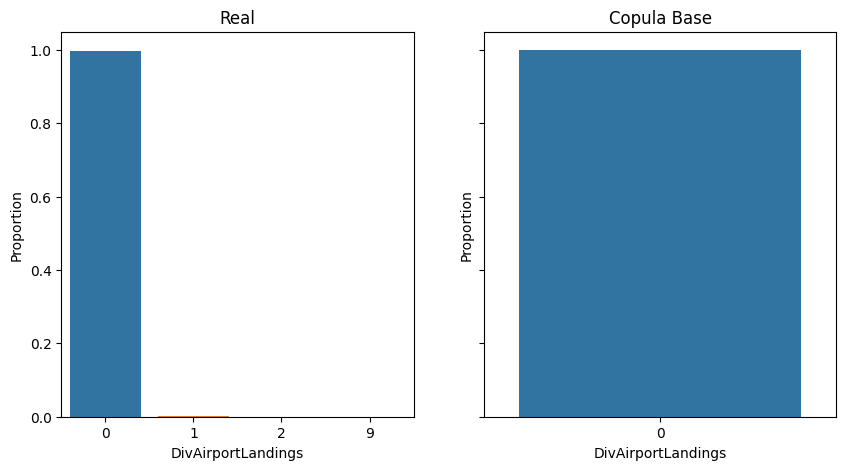

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

In [ ]:
get_column_pair_plot(
    real_data = samp_real_data,
    synthetic_data = cop_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_names=['room_rate', 'room_type'],
    metadata=metadata)

Distributions of each column

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['ArrDel15'].value_counts(normalize=True).reset_index().rename({'index':'Arr Delay','ArrDel15':'Proportion'}, axis=1)
sns.barplot(x='Arr Delay', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['ArrDel15'].value_counts(normalize=True).reset_index().rename({'index':'Arr Delay','ArrDel15':'Proportion'}, axis=1)
sns.barplot(x='Arr Delay', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['ArrivalDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'ArrivalDelayGroups','ArrivalDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='ArrivalDelayGroups', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['ArrivalDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'ArrivalDelayGroups','ArrivalDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='ArrivalDelayGroups', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['DepDel15'].value_counts(normalize=True).reset_index().rename({'index':'Dep Delay','DepDel15':'Proportion'}, axis=1)
sns.barplot(x='Dep Delay', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['DepDel15'].value_counts(normalize=True).reset_index().rename({'index':'Dep Delay','DepDel15':'Proportion'}, axis=1)
sns.barplot(x='Dep Delay', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12,5))
pct = real_data['DepartureDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'DepartureDelayGroups','DepartureDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='DepartureDelayGroups', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['DepartureDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'DepartureDelayGroups','DepartureDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='DepartureDelayGroups', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

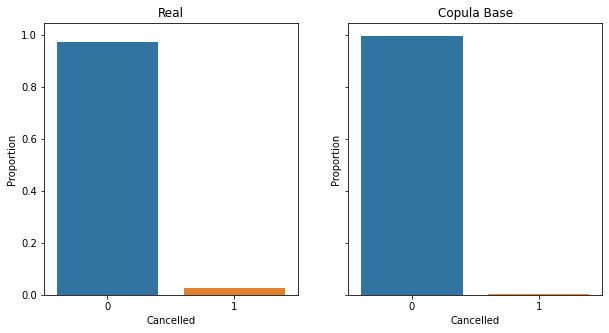

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['Cancelled'].value_counts(normalize=True).reset_index().rename({'index':'Cancelled','Cancelled':'Proportion'}, axis=1)
sns.barplot(x='Cancelled', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['Cancelled'].value_counts(normalize=True).reset_index().rename({'index':'Cancelled','Cancelled':'Proportion'}, axis=1)
sns.barplot(x='Cancelled', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

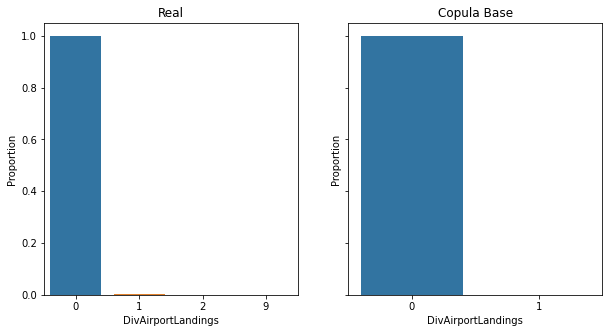

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_base_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

*** All models in the notebook use the same metrics, hence will not be explained thorouhgly here onwards ***

## Base SDV: CTGAN

CTGAN uses a deep learning generative model (GAN with generator and discriminator) 

### Fitting & Sampling

The model is initialized and fitted

In [ ]:
start = time.time()
gan_gen = CTGANSynthesizer(metadata, epochs = 10, cuda = True)
gan_gen.fit(samp_real_data)
end = time.time()

In [ ]:
gan_gen.save(
    filepath='Model/Synthesizer/gan_base.pkl'
)

The rows are sampled

In [ ]:
start_gen = time.time()
gan_base_data = gan_gen.sample(num_rows = 1000000, batch_size = 100)
end_gen = time.time()

Sampling rows: 100%|██████████| 1000000/1000000 [2:02:33<00:00, 135.99it/s]


In [ ]:
gan_base_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,2016,1,1,21,7,2016-01-31,19794,AA,N384SW,5085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,9,7,2016-01-19,19984,F9,N479HA,4033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,3,6,2016-01-09,20308,EV,N627JB,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,10,7,2016-01-29,20375,EV,N718SK,721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,19,2,2016-01-25,19396,EV,N8633A,1048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,18,1,2016-01-02,19925,OO,N6705Y,5481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,2016,1,1,20,7,2016-01-12,20308,UA,N177US,437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,2016,1,1,28,6,2016-01-11,19395,B6,N600WN,1407,...,NaN,NaN,NaN,N652BR,NaN,NaN,NaN,NaN,NaN,NaN
999998,2016,1,1,29,4,2016-01-30,20434,UA,N629JB,508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gan_base_data.to_csv(synth_data_dir + '/target_gan_base.csv', index = False)

### Evaluation

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'seconds')

Time to Fit Data:  10.57985106309255 seconds


In [ ]:
print('Time to Generate Data', (end_gen - start_gen)/60, 'minutes')

Time to Generate Data 122.56495513916016 minutes


#### Quality

In [ ]:
gan_base_quality = gan_base_data.drop(columns = ['Cancelled', 'CancellationCode', 'CarrierDelay','WeatherDelay', 'NASDelay', 
                                       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 
                                       'LongestAddGTime', 'DivAirportLandings','DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay', 
                                       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 
                                       'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 
                                       'Div2Airport', 'Diverted','Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 
                                       'Div2TotalGTime', 'Div2LongestGTime', 'Flights'])

In [ ]:
gan_base_quality_report = evaluate_quality(
    real_data = samp_real_quality,
    synthetic_data = gan_base_quality.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_quality)

Creating report: 100%|██████████| 4/4 [00:38<00:00,  9.55s/it]



Overall Quality Score: 82.83%

Properties:
Column Shapes: 83.21%
Column Pair Trends: 82.45%


In [ ]:
gan_base_quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,Year,KSComplement,1.000000
1,Quarter,KSComplement,1.000000
2,Month,KSComplement,1.000000
3,DayofMonth,KSComplement,0.910708
4,DayOfWeek,KSComplement,0.886364
5,AirlineID,KSComplement,0.771504
6,FlightNum,KSComplement,0.807304
7,OriginAirportID,KSComplement,0.807806
8,OriginAirportSeqID,KSComplement,0.796504
9,OriginCityMarketID,KSComplement,0.806729


In [ ]:
gan_base_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
gan_base_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,Quarter,Year,CorrelationSimilarity,NaN,NaN,NaN
1,Month,Year,CorrelationSimilarity,NaN,NaN,NaN
2,DayofMonth,Year,CorrelationSimilarity,NaN,NaN,NaN
3,DayOfWeek,Year,CorrelationSimilarity,NaN,NaN,NaN
4,AirlineID,Year,CorrelationSimilarity,NaN,NaN,NaN
...,...,...,...,...,...,...
1076,ArrTimeBlk,CRSElapsedTime,ContingencySimilarity,0.826644,NaN,NaN
1077,ActualElapsedTime,ArrTimeBlk,ContingencySimilarity,0.792593,NaN,NaN
1078,AirTime,ArrTimeBlk,ContingencySimilarity,0.764958,NaN,NaN
1079,ArrTimeBlk,Distance,ContingencySimilarity,0.822481,NaN,NaN


In [ ]:
gan_base_quality_report.get_visualization(property_name='Column Pair Trends')

In [ ]:
gan_base_quality_report.save('Models/Reports/gan_base_quality.pkl')

#### Diagnostics

In [ ]:
gan_base_diagnostic_report = run_diagnostic(
    real_data = samp_real_data,
    synthetic_data = gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [18:33<00:00, 278.35s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
gan_base_diagnostic_report.get_properties()

{'Coverage': 0.6192570839434894, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
gan_base_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,0.971225
4,OriginAirportID,RangeCoverage,0.888706
...,...,...,...
64,ArrTimeBlk,CategoryCoverage,1.000000
65,CancellationCode,CategoryCoverage,1.000000
66,Div1Airport,CategoryCoverage,1.000000
67,Div1TailNum,CategoryCoverage,1.000000


In [ ]:
gan_base_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
gan_base_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
gan_base_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
gan_base_diagnostic_report.get_details(property_name='Boundaries')

,Column,Metric,Diagnostic Score
0,Year,BoundaryAdherence,1.0
1,Quarter,BoundaryAdherence,1.0
2,Month,BoundaryAdherence,1.0
3,DayofMonth,BoundaryAdherence,1.0
4,DayOfWeek,BoundaryAdherence,1.0
...,...,...,...
60,Div2AirportID,BoundaryAdherence,1.0
61,Div2AirportSeqID,BoundaryAdherence,1.0
62,Div2WheelsOn,BoundaryAdherence,1.0
63,Div2TotalGTime,BoundaryAdherence,1.0


In [ ]:
gan_base_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
%ls Models

Datasets@  Models@  synth_copula.csv  synth_gan.csv  travel_insurance.csv


In [ ]:
gan_base_diagnostic_report.save('Models/Reports/gan_base_diag_report.pkl')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata
)

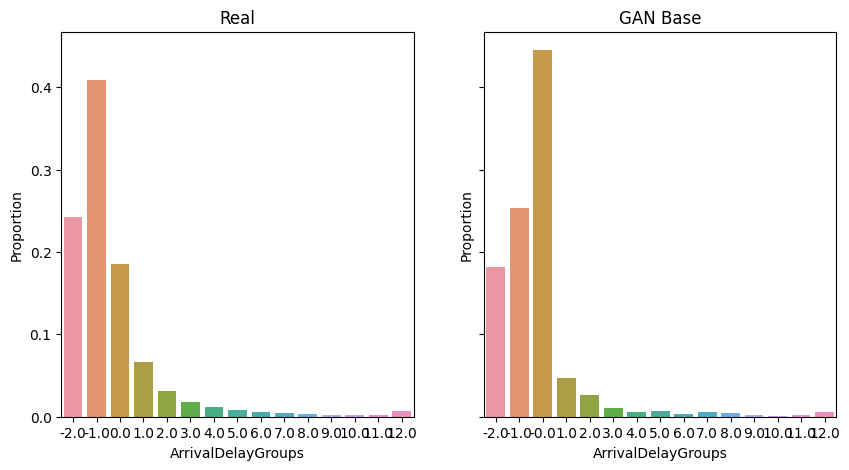

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['ArrivalDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'ArrivalDelayGroups','ArrivalDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='ArrivalDelayGroups', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = gan_base_data['ArrivalDelayGroups'].value_counts(normalize=True).reset_index().rename({'index':'ArrivalDelayGroups','ArrivalDelayGroups':'Proportion'}, axis=1)
sns.barplot(x='ArrivalDelayGroups', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('GAN Base')

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='Cancelled',
    metadata=metadata
)

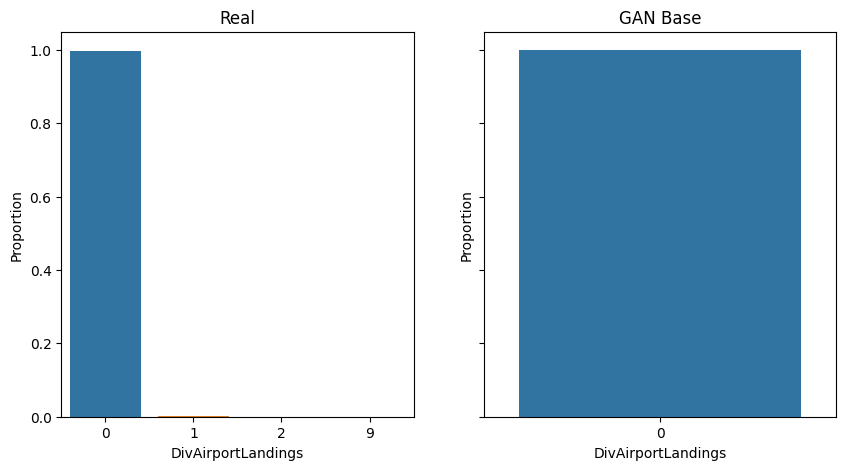

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = gan_base_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('GAN Base')

In [ ]:
get_column_pair_plot(
    real_data = samp_real_data,
    synthetic_data = gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_names=['ArrDel15', 'ArrDelay'],
    metadata=metadata)

## Base SDV: CopulaGAN

This model uses a mixture of Copula and GAN techniques to utilize the advantages of both .

### Fitting & Sampling

The models are fitted and sampled in the same manner

In [ ]:
start = time.time()
cop_gan_gen = CopulaGANSynthesizer(metadata, epochs = 10, cuda = True)
cop_gan_gen.fit(samp_real_data)
end = time.time()

In [ ]:
start_gen = time.time()
cop_gan_base_data = cop_gan_gen.sample(num_rows = 1000000, batch_size = 200)
end_gen = time.time()

Sampling rows: 100%|██████████| 1000000/1000000 [1:17:16<00:00, 215.69it/s]


In [ ]:
cop_gan_base_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,2016,1,1,23,6,2016-01-02,20259,AA,N391SW,4114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,4,5,2016-01-09,19772,AA,N426SW,3510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,15,6,2016-01-27,20235,OO,N491UA,459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,26,7,2016-01-22,19393,UA,N843UA,3247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,4,5,2016-01-28,19393,DL,N8619F,5634,...,NaN,NaN,NaN,N882AA,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,4,4,2016-01-15,19778,WN,N932EV,845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,2016,1,1,16,7,2016-01-05,19393,AA,N4UCAA,464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,2016,1,1,6,7,2016-01-29,20267,WN,N918WN,802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999998,2016,1,1,19,3,2016-01-23,19780,WN,N985DL,2334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cop_gan_base_data.to_csv(synth_data_dir + '/target_cop_gan_base.csv', index = False)

In [ ]:
cop_gan_gen.save(
    filepath='Models/Synthesizer/cop_gan_base.pkl'
)

### Evaluation

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  12.007039817174276 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  77.27086134751637 minutes


#### Quality

In [ ]:
cop_gan_base_quality = cop_gan_base_data.drop(columns = ['Cancelled', 'CancellationCode', 'CarrierDelay','WeatherDelay', 'NASDelay', 
                                       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 
                                       'LongestAddGTime', 'DivAirportLandings','DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay', 
                                       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn', 
                                       'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum', 
                                       'Div2Airport', 'Diverted','Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn', 
                                       'Div2TotalGTime', 'Div2LongestGTime', 'Flights'])

In [ ]:
cop_gan_base_quality_report = evaluate_quality(
    real_data = samp_real_quality,
    synthetic_data = cop_gan_base_quality.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_quality)

Creating report: 100%|██████████| 4/4 [00:43<00:00, 10.86s/it]



Overall Quality Score: 83.92%

Properties:
Column Shapes: 85.55%
Column Pair Trends: 82.29%


In [ ]:
cop_gan_base_quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,Year,KSComplement,1.000000
1,Quarter,KSComplement,1.000000
2,Month,KSComplement,1.000000
3,DayofMonth,KSComplement,0.810971
4,DayOfWeek,KSComplement,0.887349
5,AirlineID,KSComplement,0.701264
6,FlightNum,KSComplement,0.834143
7,OriginAirportID,KSComplement,0.854966
8,OriginAirportSeqID,KSComplement,0.840839
9,OriginCityMarketID,KSComplement,0.821178


In [ ]:
cop_gan_base_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
cop_gan_base_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,Quarter,Year,CorrelationSimilarity,NaN,NaN,NaN
1,Month,Year,CorrelationSimilarity,NaN,NaN,NaN
2,DayofMonth,Year,CorrelationSimilarity,NaN,NaN,NaN
3,DayOfWeek,Year,CorrelationSimilarity,NaN,NaN,NaN
4,AirlineID,Year,CorrelationSimilarity,NaN,NaN,NaN
...,...,...,...,...,...,...
1076,ArrTimeBlk,CRSElapsedTime,ContingencySimilarity,0.827524,NaN,NaN
1077,ActualElapsedTime,ArrTimeBlk,ContingencySimilarity,0.807561,NaN,NaN
1078,AirTime,ArrTimeBlk,ContingencySimilarity,0.806629,NaN,NaN
1079,ArrTimeBlk,Distance,ContingencySimilarity,0.710103,NaN,NaN


In [ ]:
cop_gan_base_quality_report.get_visualization(property_name='Column Pair Trends')

In [ ]:
cop_gan_base_quality_report.save('Models/Reports/cop_gan_base_quality.pkl')

#### Diagnostics

In [ ]:
cop_gan_base_diagnostic_report = run_diagnostic(
    real_data = samp_real_data,
    synthetic_data = cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [17:31<00:00, 262.77s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
cop_gan_base_diagnostic_report.get_properties()

{'Coverage': 0.6224439898789434, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
cop_gan_base_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,0.959392
4,OriginAirportID,RangeCoverage,0.872925
...,...,...,...
64,ArrTimeBlk,CategoryCoverage,1.000000
65,CancellationCode,CategoryCoverage,1.000000
66,Div1Airport,CategoryCoverage,1.000000
67,Div1TailNum,CategoryCoverage,1.000000


In [ ]:
cop_gan_base_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
cop_gan_base_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
cop_gan_base_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
cop_gan_base_diagnostic_report.get_details(property_name='Boundaries')

In [ ]:
cop_gan_base_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
cop_gan_base_diagnostic_report.save('Models/Reports/copgan_base_diag_report.pkl')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_gan_base_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='Cancelled',
    metadata=metadata
)

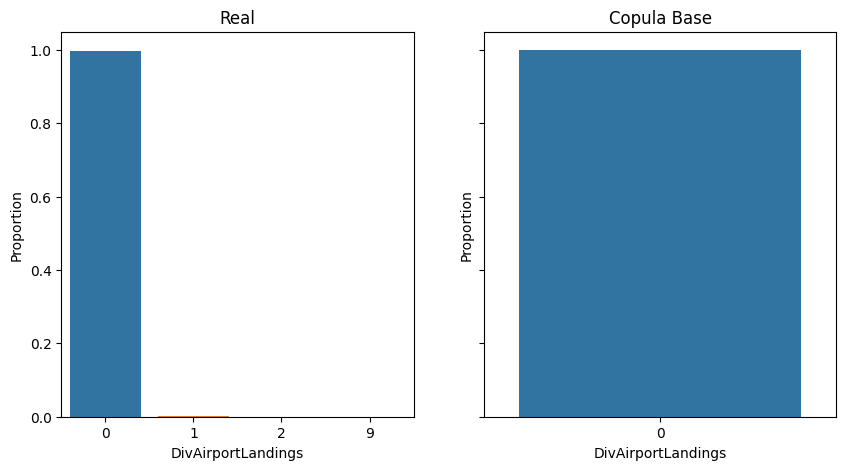

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_gan_base_data['DivAirportLandings'].value_counts(normalize=True).reset_index().rename({'index':'DivAirportLandings','DivAirportLandings':'Proportion'}, axis=1)
sns.barplot(x='DivAirportLandings', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Base')

All models have about the same performance. Copula, however, captures the correlation a lot better than GAN models and hence have higher diagnostic scores. 

# Fine Tuned SDV Generation

This section will fine tune all the models and see which one achieves the best results as follows: 
<1> Copula will experiment with the distributions
<2> GAN models will experiment with the epochs and latent dimensions. 
<3> Additional data pre-processing steps which are performed for ML will also be implemented.  

Note that hte details of fitting and sampling are omitted since they are the same and have been explained earlier.

## Fine Tune Copula 1

### Fitting & Sampling

In [ ]:
cop_fine_generate1 = GaussianCopulaSynthesizer(
    metadata, 
    enforce_min_max_values=True,
    enforce_rounding=False, 
    default_distribution='beta'
)

In [ ]:
start = time.time()
cop_fine_generate1.fit(samp_real_data)
end = time.time()

In [ ]:
start_gen = time.time()
cop_beta_data = cop_fine_generate1.sample(
    num_rows=1_000_000,
    batch_size=5000
)
end_gen = time.time()

Sampling rows: 100%|██████████| 1000000/1000000 [05:50<00:00, 2856.13it/s]


In [ ]:
cop_beta_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,2016,1,1,25,2,2016-01-29,19528,AA,N709JB,334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,2,4,2016-01-29,20274,WN,N766JB,3622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,16,4,2016-01-29,20379,NK,N216UA,201,...,NaN,NaN,NaN,N624VA,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,26,6,2016-01-29,19393,WN,N592HA,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,17,7,2016-01-17,19484,B6,N677UA,2226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,16,6,2016-01-15,19490,AS,N852UA,2297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,2016,1,1,3,7,2016-01-09,19754,B6,N3DXAA,1790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,2016,1,1,22,2,2016-01-14,19756,AA,N37427,1313,...,NaN,NaN,NaN,N624VA,NaN,NaN,NaN,NaN,NaN,NaN
999998,2016,1,1,12,5,2016-01-26,19543,AA,N118SY,2363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cop_beta_data.to_csv(synth_data_dir + '/target_copula_beta.csv', index = False)

In [ ]:
cop_fine_generate1.save(
    filepath='Models/Synthesizer/cop_beta.pkl'
)

### Evaluation

#### Time 

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  1.6174916783968607 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  7.694096386432648 minutes


#### Quality

#### Diagnostics

In [ ]:
cop_beta_diagnostic_report = run_diagnostic(
    real_data = samp_real_data,
    synthetic_data = cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [16:09<00:00, 242.42s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
! The synthetic data is missing more than 10% of the categories present in the real data


In [ ]:
cop_beta_diagnostic_report.get_properties()

{'Coverage': 0.6239142366931997, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,0.999866
4,OriginAirportID,RangeCoverage,1.000000
...,...,...,...
64,ArrTimeBlk,CategoryCoverage,1.000000
65,CancellationCode,CategoryCoverage,1.000000
66,Div1Airport,CategoryCoverage,0.081633
67,Div1TailNum,CategoryCoverage,0.076923


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Boundaries')

,Column,Metric,Diagnostic Score
0,Year,BoundaryAdherence,1.0
1,Quarter,BoundaryAdherence,1.0
2,Month,BoundaryAdherence,1.0
3,DayofMonth,BoundaryAdherence,1.0
4,DayOfWeek,BoundaryAdherence,1.0
...,...,...,...
60,Div2AirportID,BoundaryAdherence,1.0
61,Div2AirportSeqID,BoundaryAdherence,1.0
62,Div2WheelsOn,BoundaryAdherence,1.0
63,Div2TotalGTime,BoundaryAdherence,1.0


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Boundaries')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='Cancelled',
    metadata=metadata
)

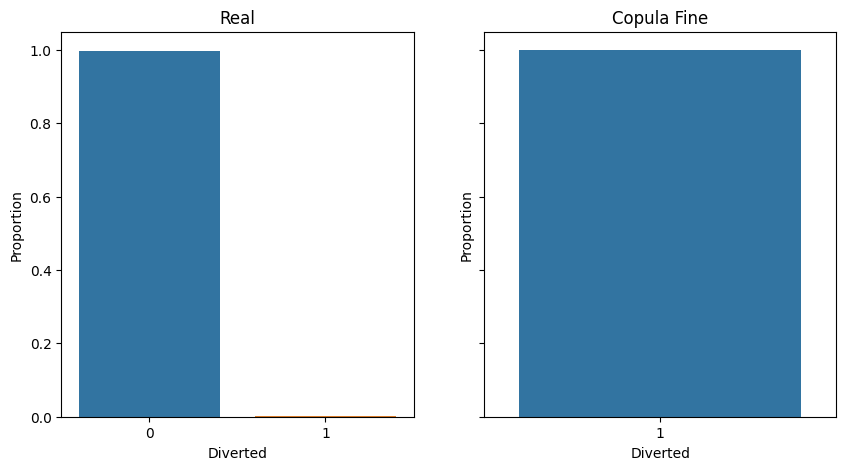

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))
pct = real_data['Diverted'].value_counts(normalize=True).reset_index().rename({'index':'Diverted','Diverted':'Proportion'}, axis=1)
sns.barplot(x='Diverted', y='Proportion', data=pct, ax = ax1)
ax1.title.set_text('Real')

pct1 = cop_beta_data['Diverted'].value_counts(normalize=True).reset_index().rename({'index':'Diverted','Diverted':'Proportion'}, axis=1)
sns.barplot(x='Diverted', y='Proportion', data=pct1, ax = ax2)
ax2.title.set_text('Copula Fine')

## Fine Tune Copula 2

### Fitting & Sampling

In [ ]:
cop_fine_generate2 = GaussianCopulaSynthesizer(
    metadata_clean, 
    enforce_min_max_values=True,
    enforce_rounding=False, 
    default_distribution='beta'
)

In [ ]:
start = time.time()
cop_fine_generate2.fit(samp_clean_data)
end = time.time()

In [ ]:
start_gen = time.time()
cop_beta_clean_data = cop_fine_generate2.sample(
    num_rows=1_000_000,
    batch_size=7000
)
end_gen = time.time()

Sampling rows: 100%|██████████| 1000000/1000000 [03:55<00:00, 4254.27it/s]


In [ ]:
cop_beta_clean_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup
0,2016,1,1,25,6,2016-01-06,19484,DL,N515NK,286,...,-32.276685,9.533702,0.000254,-1.996943,1600-1659,97.589517,82.984976,57.748303,313.815502,2
1,2016,1,1,27,5,2016-01-01,19439,WN,N829UA,702,...,-6.267430,13.023843,0.000254,-0.473041,1900-1959,150.527858,158.307297,140.387877,914.511915,6
2,2016,1,1,18,1,2016-01-06,19810,WN,N850DN,4541,...,93.034458,144.430524,1.000000,2.949385,1400-1459,86.781253,92.386067,71.462816,458.652631,5
3,2016,1,1,27,6,2016-01-07,19586,WN,N785SW,2005,...,-35.565172,0.718207,0.000254,-1.909036,0600-0659,163.249560,129.282002,139.617235,1122.575646,8
4,2016,1,1,28,5,2016-01-17,20252,DL,N607JB,5836,...,-41.986955,0.043072,0.000254,-1.998070,1100-1159,88.857920,91.189586,63.205193,328.926194,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,11,2,2016-01-28,19949,UA,N613JB,2326,...,-4.086917,17.566153,0.000254,-1.203137,0700-0759,92.023223,93.546718,60.568539,383.307971,2
999996,2016,1,1,17,3,2016-01-15,19624,EV,N720WN,1127,...,-13.572305,60.321218,0.000254,0.112149,1800-1859,136.277615,114.608256,75.955175,685.134611,3
999997,2016,1,1,26,3,2016-01-17,19547,AA,N360SW,595,...,12.419964,21.966271,0.000254,-1.214396,1100-1159,81.754851,83.272495,52.012708,434.378210,3
999998,2016,1,1,12,2,2016-01-04,19485,AA,N940WN,629,...,17.096958,33.243750,0.000254,-0.511522,2300-2359,95.162898,79.207507,61.579278,548.265152,4


In [ ]:
cop_beta_clean_data.to_csv(synth_data_dir + '/target_copula_beta.csv', index = False)

In [ ]:
cop_fine_generate2.save(
    filepath='Models/Synthesizer/cop_beta_clean.pkl'
)

### Evaluation

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  0.9188889225323995 minutes


In [ ]:
print('Time to Fit Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Fit Data:  3.9178211808204653 minutes


#### Quality

In [ ]:
cop_beta_clean_data = pd.read_csv(synth_data_dir + '/target_copula_beta.csv', low_memory = False)

In [ ]:
cop_beta_clean_data_quality_report = evaluate_quality(
    real_data = samp_clean_data,
    synthetic_data = cop_beta_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [00:45<00:00, 11.39s/it]



Overall Quality Score: 83.39%

Properties:
Column Shapes: 81.9%
Column Pair Trends: 84.87%


In [ ]:
cop_beta_clean_data_quality_report.get_details('Column Shapes')

,Column,Metric,Quality Score
0,Year,KSComplement,1.000000
1,Quarter,KSComplement,1.000000
2,Month,KSComplement,1.000000
3,DayofMonth,KSComplement,0.973755
4,DayOfWeek,KSComplement,0.924598
5,AirlineID,KSComplement,0.645534
6,FlightNum,KSComplement,0.931162
7,OriginAirportID,KSComplement,0.895636
8,OriginAirportSeqID,KSComplement,0.895566
9,OriginCityMarketID,KSComplement,0.907407


In [ ]:
cop_beta_clean_data_quality_report.get_visualization('Column Shapes')

In [ ]:
cop_beta_clean_data_quality_report.get_details('Column Pair Trends')

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,Quarter,Year,CorrelationSimilarity,NaN,NaN,NaN
1,Month,Year,CorrelationSimilarity,NaN,NaN,NaN
2,DayofMonth,Year,CorrelationSimilarity,NaN,NaN,NaN
3,DayOfWeek,Year,CorrelationSimilarity,NaN,NaN,NaN
4,AirlineID,Year,CorrelationSimilarity,NaN,NaN,NaN
...,...,...,...,...,...,...
1076,ArrTimeBlk,CRSElapsedTime,ContingencySimilarity,0.878653,NaN,NaN
1077,ActualElapsedTime,ArrTimeBlk,ContingencySimilarity,0.879193,NaN,NaN
1078,AirTime,ArrTimeBlk,ContingencySimilarity,0.875228,NaN,NaN
1079,ArrTimeBlk,Distance,ContingencySimilarity,0.873892,NaN,NaN


In [ ]:
cop_beta_clean_data_quality_report.get_visualization('Column Pair Trends')

In [ ]:
cop_beta_clean_data_quality_report.save('Models/Reports/cop_beta_clean_data_quality.pkl')

#### Diagnostics

In [ ]:
cop_beta_diagnostic_report = run_diagnostic(
    real_data = samp_clean_data,
    synthetic_data = cop_beta_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [10:15<00:00, 153.90s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
cop_beta_diagnostic_report.get_properties()

{'Coverage': 0.8896505449415554, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,0.999866
4,OriginAirportID,RangeCoverage,0.998685
5,OriginAirportSeqID,RangeCoverage,0.998657
6,OriginCityMarketID,RangeCoverage,0.997636
7,OriginStateFips,RangeCoverage,1.000000
8,OriginWac,RangeCoverage,1.000000
9,DestAirportID,RangeCoverage,0.998027


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
cop_beta_diagnostic_report.get_details(property_name='Boundaries')

,Column,Metric,Diagnostic Score
0,Year,BoundaryAdherence,1.0
1,Quarter,BoundaryAdherence,1.0
2,Month,BoundaryAdherence,1.0
3,DayofMonth,BoundaryAdherence,1.0
4,DayOfWeek,BoundaryAdherence,1.0
5,AirlineID,BoundaryAdherence,1.0
6,FlightNum,BoundaryAdherence,1.0
7,OriginAirportID,BoundaryAdherence,1.0
8,OriginAirportSeqID,BoundaryAdherence,1.0
9,OriginCityMarketID,BoundaryAdherence,1.0


In [ ]:
cop_beta_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
cop_beta_diagnostic_report.save('Models/Reports/cop_beta_clean_diag_report.pkl')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata
)

In [ ]:
get_column_plot(
    real_data = samp_real_data,
    synthetic_data= cop_beta_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata
)

## Fine Tune GAN (clean only)

In [ ]:
start = time.time()
gan_gen_clean = CTGANSynthesizer(metadata_clean,
                            epochs = 10, 
                            verbose = True,
                            cuda = True)
gan_gen_clean.fit(samp_clean_data)
end = time.time()

Epoch 1, Loss G:  3.9261,Loss D: -0.2481
Epoch 2, Loss G:  2.1053,Loss D: -0.3052
Epoch 3, Loss G:  0.8158,Loss D: -0.0576
Epoch 4, Loss G:  0.8012,Loss D:  0.1007
Epoch 5, Loss G:  0.3719,Loss D:  0.0941
Epoch 6, Loss G: -0.1824,Loss D:  0.0031
Epoch 7, Loss G:  0.3712,Loss D: -0.0807
Epoch 8, Loss G:  0.0850,Loss D: -0.0716
Epoch 9, Loss G: -0.2402,Loss D:  0.1331
Epoch 10, Loss G: -0.3319,Loss D:  0.0329


In [ ]:
start_gen = time.time()
gan_gen_clean_data = gan_gen_clean.sample(num_rows = 1000000, batch_size = 300)
end_gen = time.time()

Sampling rows: : 1000200it [21:49, 763.86it/s]


In [ ]:
gan_gen_clean_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup
0,2016,1,1,14,5,2016-01-28,20384,OO,N777QC,4732,...,1.0,0.0,0.0,-0.0,1400-1459,106.0,120.0,121.0,66.0,2
1,2016,1,1,5,4,2016-01-08,19951,UA,N935SW,1991,...,2.0,0.0,1.0,-1.0,1500-1559,87.0,157.0,57.0,805.0,4
2,2016,1,1,30,4,2016-01-04,19791,WN,N877AS,1622,...,-11.0,36.0,0.0,-0.0,0700-0759,167.0,112.0,111.0,881.0,2
3,2016,1,1,20,6,2016-01-22,20424,AA,N904DA,2630,...,-14.0,0.0,1.0,-0.0,1300-1359,142.0,50.0,191.0,300.0,2
4,2016,1,1,21,4,2016-01-17,19799,AS,N527SW,2937,...,-8.0,0.0,0.0,-2.0,1600-1659,124.0,180.0,88.0,693.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,26,5,2016-01-04,19792,EV,N6712B,240,...,-14.0,0.0,0.0,-0.0,1600-1659,133.0,98.0,320.0,165.0,2
999996,2016,1,1,9,2,2016-01-21,19983,EV,N633NK,4392,...,-18.0,3.0,0.0,-1.0,1700-1759,69.0,47.0,145.0,337.0,5
999997,2016,1,1,3,1,2016-01-21,19407,WN,N590JB,542,...,-7.0,0.0,0.0,2.0,1800-1859,211.0,34.0,106.0,211.0,2
999998,2016,1,1,14,5,2016-01-26,20312,UA,N484HA,2616,...,-12.0,0.0,1.0,-1.0,1600-1659,167.0,56.0,178.0,147.0,7


In [ ]:
gan_gen_clean.save('Models/Synthesizer/gan_gen_clean.pkl')

In [ ]:
gan_gen_clean_data.to_csv(synth_data_dir + '/target_gan_clean.csv', index = False)

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  7.071166257063548 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  21.8235830505689 minutes


In [ ]:
gan_clean_quality_report = evaluate_quality(
    real_data = samp_clean_data,
    synthetic_data = gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)


Overall Quality Score: 83.88%

Properties:
Column Shapes: 84.95%
Column Pair Trends: 82.8%


In [ ]:
gan_clean_quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,Year,KSComplement,1.000000
1,Quarter,KSComplement,1.000000
2,Month,KSComplement,1.000000
3,DayofMonth,KSComplement,0.946395
4,DayOfWeek,KSComplement,0.931255
5,AirlineID,KSComplement,0.785823
6,FlightNum,KSComplement,0.934866
7,OriginAirportID,KSComplement,0.885956
8,OriginAirportSeqID,KSComplement,0.836160
9,OriginCityMarketID,KSComplement,0.831359


In [ ]:
gan_clean_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
gan_clean_quality_report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,Quarter,Year,CorrelationSimilarity,NaN,NaN,NaN
1,Month,Year,CorrelationSimilarity,NaN,NaN,NaN
2,DayofMonth,Year,CorrelationSimilarity,NaN,NaN,NaN
3,DayOfWeek,Year,CorrelationSimilarity,NaN,NaN,NaN
4,AirlineID,Year,CorrelationSimilarity,NaN,NaN,NaN
...,...,...,...,...,...,...
1076,ArrTimeBlk,CRSElapsedTime,ContingencySimilarity,0.778841,NaN,NaN
1077,ActualElapsedTime,ArrTimeBlk,ContingencySimilarity,0.829856,NaN,NaN
1078,AirTime,ArrTimeBlk,ContingencySimilarity,0.761469,NaN,NaN
1079,ArrTimeBlk,Distance,ContingencySimilarity,0.800118,NaN,NaN


In [ ]:
gan_clean_quality_report.get_visualization(property_name='Column Pair Trends')

In [ ]:
gan_clean_quality_report.save('Models/Reports/gan_clean_quality.pkl')

In [ ]:
gan_clean_diagnostic_report = run_diagnostic(
    real_data = samp_clean_data,
    synthetic_data = gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [10:14<00:00, 153.52s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
gan_clean_diagnostic_report.get_properties()

{'Coverage': 0.8333318131429303, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
gan_clean_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,1.000000
4,OriginAirportID,RangeCoverage,0.905310
5,OriginAirportSeqID,RangeCoverage,0.953695
6,OriginCityMarketID,RangeCoverage,0.816416
7,OriginStateFips,RangeCoverage,0.987013
8,OriginWac,RangeCoverage,1.000000
9,DestAirportID,RangeCoverage,0.858951


In [ ]:
gan_clean_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
gan_clean_diagnostic_report.get_details(property_name='Synthesis')

,Metric,Diagnostic Score,Num Matched Rows,Num New Rows
0,NewRowSynthesis,1.0,0,10000


In [ ]:
gan_clean_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
gan_clean_diagnostic_report.get_details(property_name='Boundaries')

,Column,Metric,Diagnostic Score
0,Year,BoundaryAdherence,1.0
1,Quarter,BoundaryAdherence,1.0
2,Month,BoundaryAdherence,1.0
3,DayofMonth,BoundaryAdherence,1.0
4,DayOfWeek,BoundaryAdherence,1.0
5,AirlineID,BoundaryAdherence,1.0
6,FlightNum,BoundaryAdherence,1.0
7,OriginAirportID,BoundaryAdherence,1.0
8,OriginAirportSeqID,BoundaryAdherence,1.0
9,OriginCityMarketID,BoundaryAdherence,1.0


In [ ]:
gan_clean_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
gan_clean_diagnostic_report.save('Models/Reports/gan_clean_diag.pkl')

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_gen_clean_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata_clean
)

## Fine Tune GAN (epochs and dim)

### Fitting & Sampling

https://hrcak.srce.hr/file/377247
<br> https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/ 



In [ ]:
start = time.time()
gan_gen1 = CTGANSynthesizer(metadata_clean,
                            epochs = 50, 
                            verbose = True,
                            batch_size = 200,
                            discriminator_dim = (64, 64), 
                            generator_dim = (64, 64),
                            pac = 20,
                            cuda = True)
gan_gen1.fit(samp_clean_data)
end = time.time()

Epoch 1, Loss G:  4.4140,Loss D:  0.0815
Epoch 2, Loss G:  2.5069,Loss D: -0.2127
Epoch 3, Loss G:  2.7100,Loss D:  0.3530
Epoch 4, Loss G:  2.3330,Loss D:  0.2343
Epoch 5, Loss G:  2.6843,Loss D:  0.1104
Epoch 6, Loss G:  2.2715,Loss D: -0.5227
Epoch 7, Loss G:  1.4324,Loss D: -0.0734
Epoch 8, Loss G:  1.9608,Loss D:  0.0592
Epoch 9, Loss G:  1.6941,Loss D: -0.6854
Epoch 10, Loss G:  1.7962,Loss D:  0.9500
Epoch 11, Loss G:  1.1477,Loss D: -0.5512
Epoch 12, Loss G:  1.6175,Loss D:  0.2868
Epoch 13, Loss G:  0.7078,Loss D:  0.1536
Epoch 14, Loss G:  1.5148,Loss D:  0.3614
Epoch 15, Loss G:  1.4962,Loss D: -0.5561
Epoch 16, Loss G:  1.4429,Loss D:  0.1532
Epoch 17, Loss G:  0.0572,Loss D:  0.6081
Epoch 18, Loss G:  2.0958,Loss D:  0.4561
Epoch 19, Loss G:  1.2650,Loss D: -0.5340
Epoch 20, Loss G:  1.6186,Loss D:  0.3001
Epoch 21, Loss G:  0.8539,Loss D: -0.0918
Epoch 22, Loss G: -0.0817,Loss D: -0.3338
Epoch 23, Loss G:  0.9418,Loss D:  0.5702
Epoch 24, Loss G:  1.0729,Loss D: -0.2996
E

Text(0, 0.5, 'Loss')

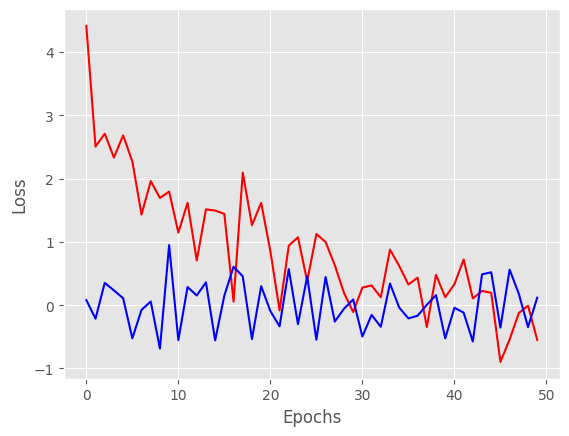

In [ ]:
loss_g = [4.4140, 2.5069, 2.7100, 2.3330, 2.6843, 2.2715, 1.4324,1.9608,1.6941,1.7962,
          1.1477,1.6175,0.7078, 1.5148,1.4962, 1.4429,0.0572, 2.0958, 1.2650,1.6186,
          0.8539, -0.0817,  0.9418,  1.0729,  0.3797,  1.1259,  0.9991,0.6335, 0.1956, -0.1084,
          0.2788, 0.3127,0.1260,0.8781, 0.6217, 0.3266,0.4359, -0.3439, 0.4803,  0.1259,
          0.3319,0.7227, 0.1069, 0.2255,  0.1962, -0.8961,-0.5416, -0.1227, -0.0079,-0.5484]

loss_d = [0.0815, -0.2127,0.3530,0.2343,0.1104, -0.5227, -0.0734, 0.0592, -0.6854, 0.9500,
          -0.5512,0.2868,0.1536,0.3614, -0.5561, 0.1532,0.6081, 0.4561, -0.5340, 0.3001,
          -0.0918, -0.3338,  0.5702, -0.2996,  0.4533, -0.5453,  0.4462, -0.2586, -0.0559, 
          0.0908, -0.4947,-0.1525,-0.3414,0.3430,-0.0375,-0.2087, -0.1656,0.0068,0.1588,
          -0.5249, -0.0404,-0.1165,-0.5733,  0.4879, 0.5208, -0.3532,  0.5627,  0.1797, -0.3461,0.1189]

plt.style.use('ggplot')
plt.plot(loss_g, "r")
plt.plot(loss_d, "b")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
start_gen = time.time()
gan_fine_data = gan_gen1.sample(num_rows = 1000000, batch_size = 300)
end_gen = time.time()

Sampling rows: : 1000200it [23:07, 720.72it/s]


In [ ]:
gan_fine_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,Carrier,TailNum,FlightNum,...,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup
0,2016,1,1,16,5,2016-01-22,19795,DL,N573UW,2272,...,-33.0,13.0,0.0,-1.0,0700-0759,57.0,39.0,22.0,1004.0,2
1,2016,1,1,28,1,2016-01-06,19393,DL,N12175,641,...,26.0,24.0,0.0,-1.0,0001-0559,125.0,118.0,148.0,439.0,2
2,2016,1,1,1,2,2016-01-13,20325,OO,N013AA,409,...,-21.0,0.0,0.0,-1.0,2000-2059,73.0,69.0,25.0,382.0,1
3,2016,1,1,29,1,2016-01-28,19975,UA,N928AT,5740,...,155.0,90.0,0.0,3.0,1400-1459,111.0,74.0,182.0,766.0,9
4,2016,1,1,27,6,2016-01-16,19412,OO,N7745A,1055,...,22.0,0.0,0.0,-2.0,1600-1659,58.0,163.0,60.0,552.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016,1,1,29,5,2016-01-17,19784,OO,N491HA,1292,...,-2.0,0.0,0.0,1.0,1900-1959,93.0,71.0,40.0,726.0,5
999996,2016,1,1,2,6,2016-01-30,19793,OO,N635DL,5013,...,4.0,0.0,0.0,-0.0,2200-2259,74.0,88.0,121.0,102.0,4
999997,2016,1,1,3,1,2016-01-09,21077,B6,N17753,5187,...,103.0,44.0,0.0,-1.0,2200-2259,143.0,33.0,108.0,1494.0,3
999998,2016,1,1,6,1,2016-01-05,19794,WN,N7814B,2210,...,-9.0,0.0,0.0,-2.0,1200-1259,289.0,211.0,271.0,904.0,2


In [ ]:
gan_gen1.save(
    filepath='Models/Synthesizer/gen_fine1.pkl'
)

In [ ]:
gan_fine_data.to_csv(synth_data_dir + '/target_gan_fine.csv', index = False)

### Evaluation

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  25.287420495351157 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  23.129992787043253 minutes


#### Quality

In [ ]:
gan_fine_data = pd.read_csv(synth_data_dir + '/target_gan_fine.csv', low_memory = False)

In [ ]:
gan_fine_quality_report = evaluate_quality(
    real_data = samp_clean_data,
    synthetic_data = gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)


Overall Quality Score: 84.16%

Properties:
Column Shapes: 86.93%
Column Pair Trends: 81.39%


In [ ]:
gan_fine_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
gan_fine_quality_report.get_visualization(property_name='Column Pair Trends')

#### Diagnostic

In [ ]:
gan_fine_diagnostic_report = run_diagnostic(
    real_data = samp_clean_data,
    synthetic_data = gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [10:52<00:00, 163.15s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
gan_fine_diagnostic_report.get_properties()

{'Coverage': 0.8714926927436832, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
gan_fine_diagnostic_report.save('Models/Reports/gan_fine1_diag_report.pkl')

In [ ]:
gan_fine_diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Diagnostic Score
0,DayofMonth,RangeCoverage,1.000000
1,DayOfWeek,RangeCoverage,1.000000
2,AirlineID,RangeCoverage,1.000000
3,FlightNum,RangeCoverage,1.000000
4,OriginAirportID,RangeCoverage,0.967121
5,OriginAirportSeqID,RangeCoverage,0.957756
6,OriginCityMarketID,RangeCoverage,0.936497
7,OriginStateFips,RangeCoverage,1.000000
8,OriginWac,RangeCoverage,1.000000
9,DestAirportID,RangeCoverage,1.000000


In [ ]:
gan_fine_diagnostic_report.get_visualization(property_name='Coverage')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata_clean
)

## Fine Tune GAN (Privacy + Longer Epochs)

In [ ]:
gan_gen2 = CTGANSynthesizer(metadata_clean,
                            epochs = 100, 
                            verbose = True,
                            batch_size = 1000,
                            discriminator_dim = (64, 64), 
                            generator_dim = (64, 64),
                            pac = 20,
                            cuda = True)

In [ ]:
gan_gen2.auto_assign_transformers(samp_clean_data)
gan_gen2.get_transformers()

In [ ]:
start = time.time()
gan_gen2.fit(samp_clean_data)
end = time.time()

Epoch 1, Loss G:  5.7930,Loss D: -2.6084
Epoch 2, Loss G:  4.5562,Loss D: -0.8878
Epoch 3, Loss G:  4.5480,Loss D: -0.2351
Epoch 4, Loss G:  4.6908,Loss D: -0.4953
Epoch 5, Loss G:  4.3472,Loss D:  0.0260
Epoch 6, Loss G:  3.2007,Loss D:  0.0483
Epoch 7, Loss G:  2.2688,Loss D: -0.3465
Epoch 8, Loss G:  1.9979,Loss D: -0.2667
Epoch 9, Loss G:  2.1537,Loss D:  0.2051
Epoch 10, Loss G:  1.8984,Loss D:  0.0636
Epoch 11, Loss G:  1.3389,Loss D:  0.2601
Epoch 12, Loss G:  1.3833,Loss D:  0.0378
Epoch 13, Loss G:  1.8356,Loss D: -0.4419
Epoch 14, Loss G:  1.0090,Loss D:  0.3536
Epoch 15, Loss G:  1.1560,Loss D: -0.1090
Epoch 16, Loss G:  1.1004,Loss D:  0.1819
Epoch 17, Loss G:  1.4573,Loss D: -0.0022
Epoch 18, Loss G:  0.4767,Loss D: -0.0740
Epoch 19, Loss G:  0.5453,Loss D:  0.0151
Epoch 20, Loss G:  0.8747,Loss D:  0.1353
Epoch 21, Loss G:  0.7268,Loss D:  0.0575
Epoch 22, Loss G: -0.2250,Loss D:  0.1158
Epoch 23, Loss G: -0.2497,Loss D:  0.0240
Epoch 24, Loss G: -0.6472,Loss D: -0.0576
E

In [ ]:
start_gen = time.time()
gan_fine2_data = gan_gen2.sample(num_rows = 1000000, batch_size = 300)
end_gen = time.time()

Sampling rows: : 1000200it [24:34, 678.31it/s]


In [ ]:
gan_fine2_data.to_csv(synth_data_dir + '/target_gan_fine2.csv', index = False)

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  32.29578291972478 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  24.57590869665146 minutes


In [ ]:
gan_clean_quality_report = evaluate_quality(
    real_data = samp_clean_data,
    synthetic_data = gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report:  50%|█████     | 2/4 [00:01<00:01,  1.22it/s]/usr/local/lib/python3.9/dist-packages/sdmetrics/column_pairs/statistical/correlation_similarity.py:60: ConstantInputWarning: One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.
  warnings.warn(ConstantInputWarning(msg))
/usr/local/lib/python3.9/dist-packages/sdmetrics/column_pairs/statistical/correlation_similarity.py:60: ConstantInputWarning: One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.
  warnings.warn(ConstantInputWarning(msg))
/usr/local/lib/python3.9/dist-packages/sdmetrics/column_pairs/statistical/correlation_similarity.py:60: ConstantInputWarning: One or both of the input arrays is constant. The CorrelationSimilarity metric is either undefined or infinite.
  warnings.warn(ConstantInputWarning(msg))
/usr/local/lib/python3.9/dist-packages/sdmetrics/column_pairs/statistical/correlation_similarity.p


Overall Quality Score: 84.79%

Properties:
Column Shapes: 86.69%
Column Pair Trends: 82.88%


In [ ]:
gan_clean_quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
gan_clean_quality_report.get_visualization(property_name='Column Pair Trends')

In [ ]:
gan_clean_quality_report.save('Models/Reports/gan_fine2_quality.pkl')

In [ ]:
gan_fine2_diagnostic_report = run_diagnostic(
    real_data = samp_clean_data,
    synthetic_data = gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [09:45<00:00, 146.37s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
gan_fine2_diagnostic_report.get_properties()

{'Coverage': 0.8640425180638546, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
gan_fine2_diagnostic_report.get_visualization(property_name='Boundaries')

In [ ]:
gan_fine2_diagnostic_report.get_visualization(property_name='Synthesis')

In [ ]:
gan_fine2_diagnostic_report.get_visualization(property_name='Coverage')

In [ ]:
gan_fine2_diagnostic_report.save('Models/Reports/gan_fine2_diag.pkl')

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= gan_fine2_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata_clean
)

## Fine Tune CopGAN

### Fitting & Sampling

In [ ]:
cop_gan_fine_gen = CopulaGANSynthesizer(metadata_clean,
                            epochs = 50, 
                            verbose = True,
                            batch_size = 100,
                            discriminator_dim = (64, 64), 
                            generator_dim = (64, 64),
                            pac = 10,
                            cuda = True)

In [ ]:
start = time.time()
cop_gan_fine = cop_gan_fine_gen.fit(samp_clean_data)
end = time.time()

Epoch 1, Loss G:  3.9910,Loss D: -0.0526
Epoch 2, Loss G:  2.4053,Loss D: -0.0211
Epoch 3, Loss G:  2.4779,Loss D: -0.3745
Epoch 4, Loss G:  1.3091,Loss D:  0.0941
Epoch 5, Loss G:  2.1376,Loss D:  0.0479
Epoch 6, Loss G:  2.3943,Loss D:  0.0907
Epoch 7, Loss G:  2.6132,Loss D: -0.1448
Epoch 8, Loss G:  1.5123,Loss D: -0.1302
Epoch 9, Loss G:  2.0796,Loss D: -0.9048
Epoch 10, Loss G:  1.1958,Loss D: -0.0426
Epoch 11, Loss G:  0.4706,Loss D: -0.6029
Epoch 12, Loss G:  1.0186,Loss D: -0.3147
Epoch 13, Loss G:  1.5527,Loss D: -0.6737
Epoch 14, Loss G:  0.9095,Loss D:  0.0020
Epoch 15, Loss G:  0.5056,Loss D:  0.3146
Epoch 16, Loss G:  1.2465,Loss D:  0.1887
Epoch 17, Loss G:  0.5698,Loss D: -0.8672
Epoch 18, Loss G:  0.5042,Loss D: -0.1550
Epoch 19, Loss G:  0.7734,Loss D: -1.0840
Epoch 20, Loss G:  1.1149,Loss D:  0.0951
Epoch 21, Loss G:  1.0158,Loss D: -0.6929
Epoch 22, Loss G:  0.8352,Loss D: -0.0068
Epoch 23, Loss G:  0.5392,Loss D:  0.2674
Epoch 24, Loss G:  2.3753,Loss D: -0.8059
E

In [ ]:
start_gen = time.time()
cop_gan_fine_data = cop_gan_fine_gen.sample(num_rows = 1000000, batch_size = 300)
end_gen = time.time()

Sampling rows: : 1000200it [32:51, 507.36it/s]


In [ ]:
cop_gan_fine_data.to_csv(synth_data_dir + 'target_cop_gan_fine.csv', index = False)

In [ ]:
cop_gan_fine_gen.save('Models/Synthesizer/cop_gan_fine.pkl')

### Evaluation

#### Time

In [ ]:
print('Time to Fit Data: ', (end-start)/60, 'minutes')

Time to Fit Data:  34.00355455478032 minutes


In [ ]:
print('Time to Generate Data: ', (end_gen-start_gen)/60, 'minutes')

Time to Generate Data:  32.856289494037625 minutes


#### Quality

In [ ]:
cop_gan_fine_quality_report = evaluate_quality(
    real_data = samp_clean_data,
    synthetic_data = cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [00:43<00:00, 10.98s/it]



Overall Quality Score: 84.15%

Properties:
Column Shapes: 86.8%
Column Pair Trends: 81.49%


In [ ]:
cop_gan_fine_quality_report.save('Models/Reports/cop_gan_fine_quality_report.pkl')

In [ ]:
cop_gan_fine_quality_report.get_visualization(property_name = 'Column Shapes')

In [ ]:
cop_gan_fine_quality_report.get_visualization(property_name = 'Column Pair Trends')

#### Diagnostic

In [ ]:
cop_gan_fine_diag_report = run_diagnostic(
    real_data = samp_clean_data,
    synthetic_data = cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    metadata=metadata_clean)

Creating report: 100%|██████████| 4/4 [10:58<00:00, 164.68s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [ ]:
cop_gan_fine_diag_report.save('Models/Reports/cop_gan_fine_diag_report.pkl')

In [ ]:
cop_gan_fine_diag_report.get_properties()

{'Coverage': 0.9006849446935903, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [ ]:
cop_gan_fine_diag_report.get_visualization(property_name = 'Coverage')

In [ ]:
cop_gan_fine_diag_report.get_visualization(property_name = 'Boundaries')

In [ ]:
cop_gan_fine_diag_report.get_visualization(property_name = 'Synthesis')

#### Other Metrics

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='ArrivalDelayGroups',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDelay',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepDel15',
    metadata=metadata_clean
)

In [ ]:
get_column_plot(
    real_data = samp_clean_data,
    synthetic_data= cop_gan_fine_data.sample(frac=0.1, replace=False, random_state=4266),
    column_name='DepartureDelayGroups',
    metadata=metadata_clean
)

# HMA Synthesizer

In [ ]:
from sdv.metadata import MultiTableMetadata
metadata = MultiTableMetadata()

In [ ]:
metadata.detect_table_from_dataframe(
    table_name='target',
    data=samp_real_data
)

InvalidMetadataError: ignored

In [ ]:

from sdv.multi_table import HMASynthesizer
​
# Step 1: Create the synthesizer
synthesizer = HMASynthesizer(metadata)
​
# Step 2: Train the synthesizer
synthesizer.fit(real_data)
​
# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=100)

The HMA synthesizer is unable to detect more than one table for the metadata.

# VAE

VAE is another model that is able to encode and decode to generate outputs that replicate the input. The following is a trial of the process

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class VAE(nn.Module):ss
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    def encode(self, x):
        h = self.encoder(x)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

In [ ]:
# Define the training loop
def train_vae(model, train_loader, learning_rate, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            # Reset the gradients
            optimizer.zero_grad()
            
            # Forward pass
            x = batch.float()
            x_hat, mu, logvar = model(x)
            
            # Compute the loss
            reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = (reconstruction_loss + kl_divergence_loss) / x.size(0)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            epoch_loss += loss.item()
            
        print('Epoch %d Loss: %.4f' % (epoch+1, epoch_loss / len(train_loader)))

In [ ]:
# Load and preprocess the data
from sklearn.preprocessing import MinMaxScaler

cat = []
num = []
for col in samp_clean_data.columns: 
  if samp_clean_data[col].dtype == 'object': 
    cat.append(col)
  else: 
    num.append(col)

#one-hot encoding and drop NAs
df = pd.get_dummies(samp_clean_data, columns=cat)
df.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

# Clip the data to the range [0, 1]
data = np.clip(data, a_min=0, a_max=1)

# Convert the data to a PyTorch tensor
data_tensor = torch.from_numpy(data)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data_tensor, [train_size, test_size])

In [ ]:
# Initialize the VAE model and optimizer
input_dim = data.shape[1]
hidden_dim = 256
latent_dim = 50
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.05)

# Train the VAE model
start = time.time()
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)
vae_fit = train_vae(vae, train_loader, learning_rate=0.01, num_epochs=250)
end = time.time()

Epoch 1 Loss: 99.7731
Epoch 2 Loss: 67.4840
Epoch 3 Loss: 66.1777
Epoch 4 Loss: 65.1263
Epoch 5 Loss: 64.2080
Epoch 6 Loss: 63.9575
Epoch 7 Loss: 62.9554
Epoch 8 Loss: 62.4288
Epoch 9 Loss: 62.3648
Epoch 10 Loss: 62.1654
Epoch 11 Loss: 62.1190
Epoch 12 Loss: 62.1023
Epoch 13 Loss: 62.0986
Epoch 14 Loss: 62.0754
Epoch 15 Loss: 62.0730
Epoch 16 Loss: 62.0622
Epoch 17 Loss: 62.0536
Epoch 18 Loss: 62.0467
Epoch 19 Loss: 62.0399
Epoch 20 Loss: 62.0468
Epoch 21 Loss: 62.0323
Epoch 22 Loss: 62.0155
Epoch 23 Loss: 62.0031
Epoch 24 Loss: 61.9975
Epoch 25 Loss: 61.9757
Epoch 26 Loss: 61.9587
Epoch 27 Loss: 61.9441
Epoch 28 Loss: 61.9321
Epoch 29 Loss: 61.9165
Epoch 30 Loss: 61.9097
Epoch 31 Loss: 61.8970
Epoch 32 Loss: 61.8953
Epoch 33 Loss: 61.8899
Epoch 34 Loss: 61.8867
Epoch 35 Loss: 61.8842
Epoch 36 Loss: 61.8692
Epoch 37 Loss: 61.8682
Epoch 38 Loss: 61.8606
Epoch 39 Loss: 61.8599
Epoch 40 Loss: 61.8551
Epoch 41 Loss: 61.8522
Epoch 42 Loss: 61.8464
Epoch 43 Loss: 61.8418
Epoch 44 Loss: 61.83

In [ ]:
torch.save(vae.state_dict(), 'Models/Synthesizer/trained_vae.pt')

In [ ]:
input_dim = data.shape[1]
hidden_dim = 256
latent_dim = 50
vae = VAE(input_dim, hidden_dim, latent_dim)

In [ ]:
start_gen = time.time()
with torch.no_grad():
    z = torch.randn(100000, 256)
    synth_np = vae.decode(z).numpy()
end_gen = time.time()

In [ ]:
np.save('Datasets/Synthetic/vae_gen.npy', synth_np)

In [ ]:
synth_scaled = scaler.inverse_transform(synth_np)
cols = df.columns
vae_base_data = pd.DataFrame(synth_scaled, columns=cols)

In [ ]:
vae_data = vae_base_data.round()

In [ ]:
vae_base_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,...,ArrTimeBlk_1400-1459,ArrTimeBlk_1500-1559,ArrTimeBlk_1600-1659,ArrTimeBlk_1700-1759,ArrTimeBlk_1800-1859,ArrTimeBlk_1900-1959,ArrTimeBlk_2000-2059,ArrTimeBlk_2100-2159,ArrTimeBlk_2200-2259,ArrTimeBlk_2300-2359
0,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
1,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
2,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
3,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
4,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
99996,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
99997,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098
99998,2016.0,1.0,1.0,15.883206,4.009663,19886.652344,1954.538696,12707.195312,1270732.5,31723.373047,...,0.063395,0.050701,0.081762,0.057323,0.064243,0.057518,0.062854,0.069346,0.051753,0.039098


In [ ]:
vae_data.to_csv('Datasets/Synthetic/vae_base.csv', index = False)

In [ ]:
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,...,ArrTimeBlk_1400-1459,ArrTimeBlk_1500-1559,ArrTimeBlk_1600-1659,ArrTimeBlk_1700-1759,ArrTimeBlk_1800-1859,ArrTimeBlk_1900-1959,ArrTimeBlk_2000-2059,ArrTimeBlk_2100-2159,ArrTimeBlk_2200-2259,ArrTimeBlk_2300-2359
88207,2016,1,1,4,1,20409,466,14635,1463502,31714,...,1,0,0,0,0,0,0,0,0,0
239870,2016,1,1,5,2,19393,995,12892,1289203,32575,...,0,0,1,0,0,0,0,0,0,0
276457,2016,1,1,16,6,19393,788,12889,1288903,32211,...,0,0,0,0,0,0,0,0,0,0
341527,2016,1,1,6,3,19790,1151,13487,1348702,31650,...,0,0,0,0,0,0,0,0,0,0
303549,2016,1,1,23,6,19393,608,10693,1069302,30693,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279801,2016,1,1,4,1,19977,351,15016,1501603,31123,...,0,0,0,0,0,0,0,0,0,0
409828,2016,1,1,4,1,19790,2026,10397,1039705,30397,...,0,0,0,0,0,0,0,0,0,0
109762,2016,1,1,31,7,20409,221,10721,1072102,30721,...,0,0,0,0,0,0,0,0,0,0
376984,2016,1,1,20,3,19790,2532,13204,1320402,31454,...,0,0,0,0,1,0,0,0,0,0
